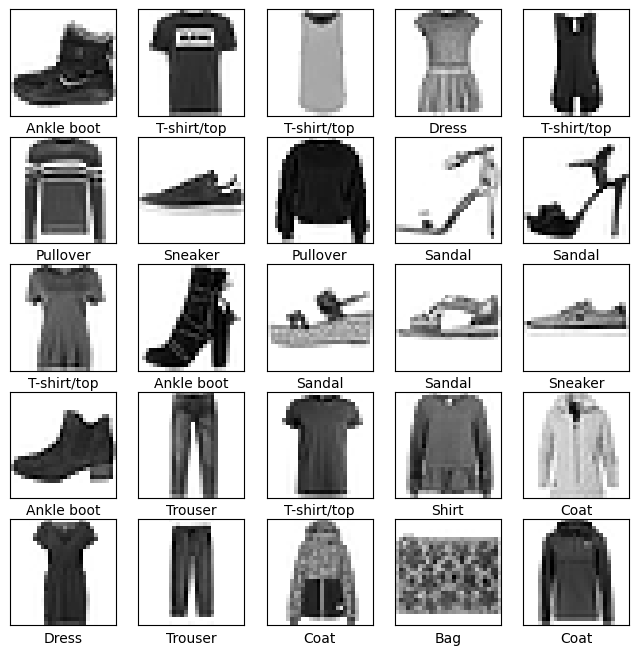

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input,BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

x_train = x_train[y_train==3]
y_train = y_train[y_train==3]
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 300

In [5]:
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)
x_train = x_train / 255
x_test = x_test / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
train_dataset =tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# формування моделі
hidden_dim = 2
def dropout_and_batch():
 return Dropout(0.3)(BatchNormalization())
# генератор
generator = tf.keras.Sequential([
Dense(7*7*256, activation='relu', input_shape=(hidden_dim,)),
    BatchNormalization(),
    Reshape((7, 7, 256)),
Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',
activation='relu'),
BatchNormalization(),
Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
activation='relu'),
BatchNormalization(),
Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
activation='relu'),
])


# дискриминатор
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))


# втрати
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
 loss = cross_entropy(tf.ones_like(fake_output), fake_output)
 return loss
def discriminator_loss(real_output, fake_output):
 real_loss = cross_entropy(tf.ones_like(real_output), real_output)
 fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
 total_loss = real_loss + fake_loss
 return total_loss
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
import tensorflow as tf
import time




@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

def train(dataset, epochs):
    history = []
    MAX_PRINT_LABEL = 10
    th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)
    for epoch in range(1, epochs+1):
        print(f'{epoch}/{EPOCHS}: ', end='')
        start = time.time()
        n = 0
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if n % th == 0:
                print('=', end='')
            n += 1
        history.append(gen_loss_epoch / n)
        print(': ' + str(history[-1]))
        print('час епохи {} складає {} секунд'.format(epoch + 1, time.time() - start))

    return history

(6000, 28, 28) (6000,)


1/20: ==========: tf.Tensor(0.58841354, shape=(), dtype=float32)
час епохи 2 складає 65.48090982437134 секунд
2/20: ==========: tf.Tensor(0.8474207, shape=(), dtype=float32)
час епохи 3 складає 61.38926410675049 секунд
3/20: ==========: tf.Tensor(0.8318052, shape=(), dtype=float32)
час епохи 4 складає 62.41506099700928 секунд
4/20: ==========: tf.Tensor(0.8626523, shape=(), dtype=float32)
час епохи 5 складає 62.338191747665405 секунд
5/20: ==========: tf.Tensor(0.820963, shape=(), dtype=float32)
час епохи 6 складає 62.20563268661499 секунд
6/20: ==========: tf.Tensor(0.759022, shape=(), dtype=float32)
час епохи 7 складає 62.28377842903137 секунд
7/20: ==========: tf.Tensor(0.73160696, shape=(), dtype=float32)
час епохи 8 складає 61.99502778053284 секунд
8/20: ==========: tf.Tensor(0.62719846, shape=(), dtype=float32)
час епохи 9 складає 61.915249824523926 секунд
9/20: ==========: tf.Tensor(0.5706199, shape=(), dtype=float32)
час епохи 10 складає 61.850058794021606 секунд
10/20: =======

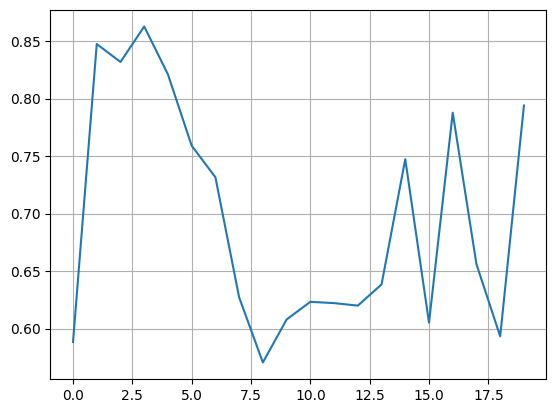

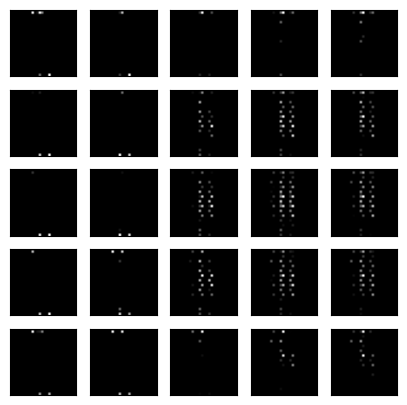

In [6]:
# запуск процеса навчання
EPOCHS = 20
history = train(train_dataset, EPOCHS)
plt.plot(history)
plt.grid(True)
# відображення результатів генерації
n = 2
total = 2*n+1
plt.figure(figsize=(total, total))
num = 1
for i in range(-n, n+1):
 for j in range(-n, n+1):
  ax = plt.subplot(total, total, num)
  num += 1
  img = generator.predict(np.expand_dims([0.5*i/n, 0.5*j/n], axis=0))
  plt.imshow(img[0,:,:,0], cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [7]:
for i, loss in enumerate(history):
    print(f"Епоха {i +1}: {loss}")

Епоха 1: 0.5884135365486145
Епоха 2: 0.8474206924438477
Епоха 3: 0.8318052291870117
Епоха 4: 0.8626523017883301
Епоха 5: 0.8209630250930786
Епоха 6: 0.7590219974517822
Епоха 7: 0.7316069602966309
Епоха 8: 0.6271984577178955
Епоха 9: 0.5706198811531067
Епоха 10: 0.6079774498939514
Епоха 11: 0.6233313679695129
Епоха 12: 0.6222213506698608
Епоха 13: 0.6200302839279175
Епоха 14: 0.6384404897689819
Епоха 15: 0.7472913265228271
Епоха 16: 0.6052147746086121
Епоха 17: 0.7877019047737122
Епоха 18: 0.6559995412826538
Епоха 19: 0.5933459401130676
Епоха 20: 0.7939549684524536
